MAnorm2 1.2.0 2021-09-10

Loading required package: limma

Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.

Registering fonts with R



During the local regression procedure:
After iteration 1: 2 (0.00%) outlier(s) detected
After iteration 2: 4 (0.00%) outlier(s) detected
After iteration 3: 4 (0.00%) outlier(s) detected
Converged.



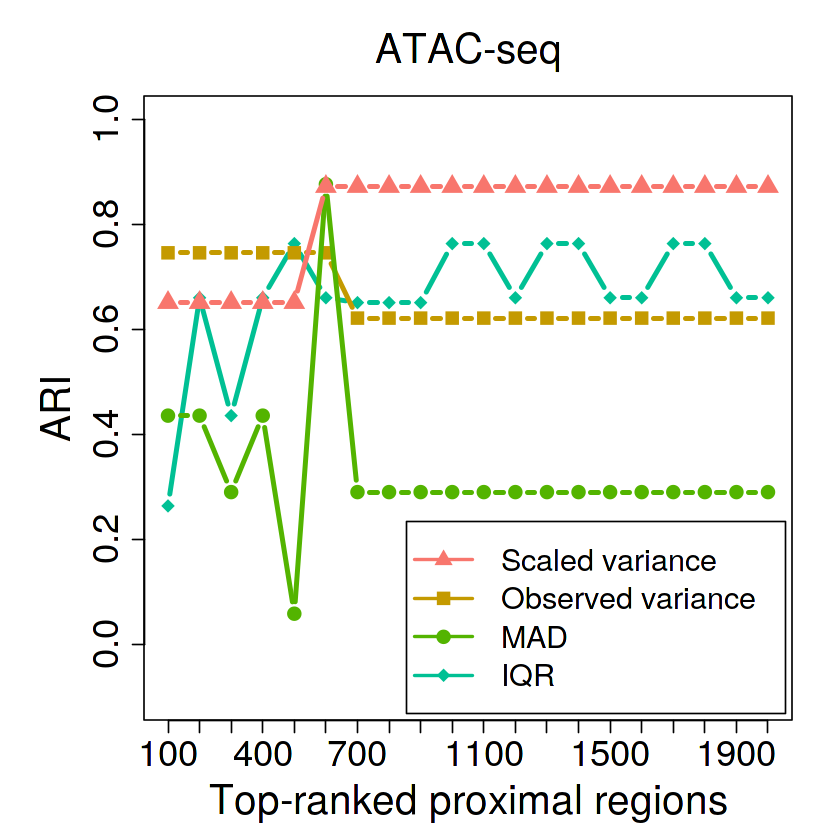

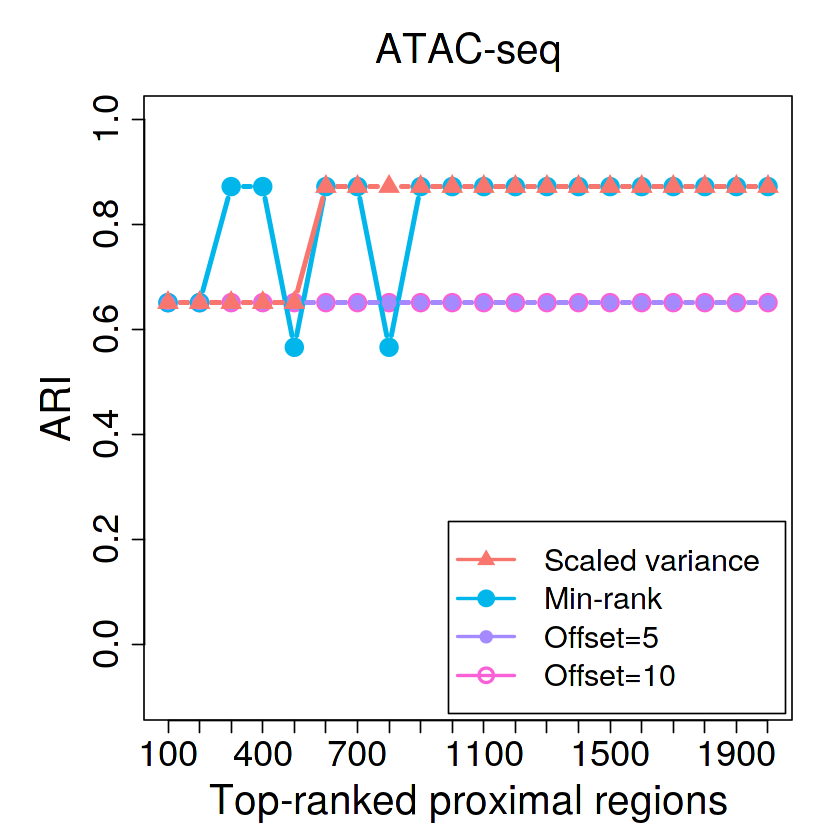

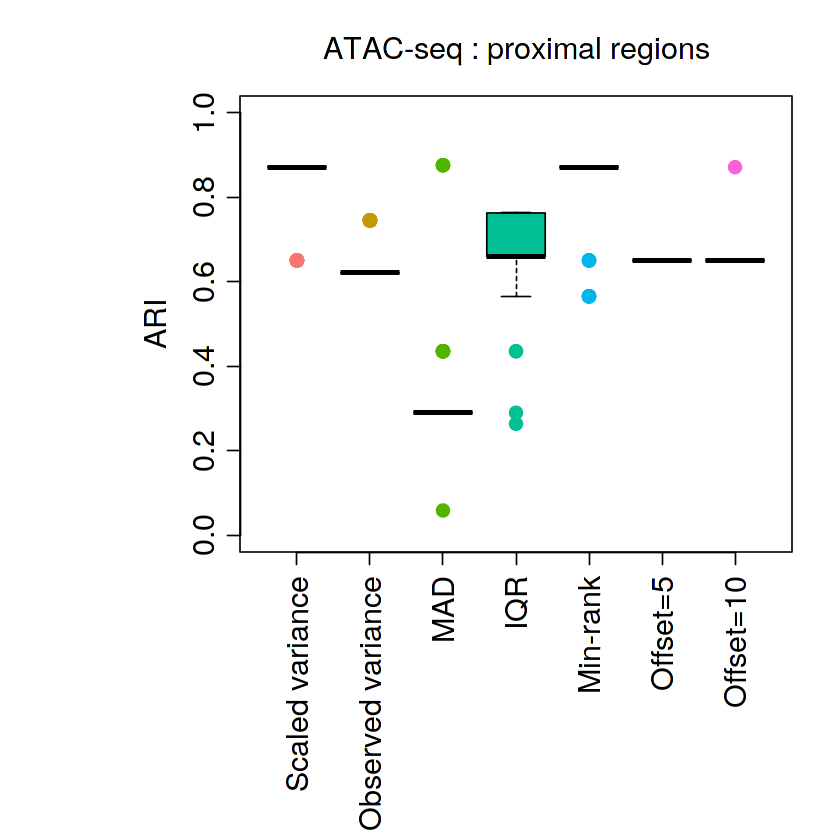

In [1]:
#import MAnorm2 packages
library(MAnorm2)
library(statmod)
library(scales)
library(edgeR)
library(preprocessCore)
library(RColorBrewer)
library(mclust)
library(extrafont)

color.list<-hue_pal()(7)

#calculate single end p-value
single.end.pvalue<-function(biocond){
    df<-attr(biocond,"df")
    p.value<-pf(biocond$fold.change,df[1],df[2],lower.tail=F)
    return(p.value)
}

path<-'/media/chenhaojie/shao_lab_Disk02/Data_set_used_in_MAnorm2_and_HyperChIP/Hyper_variable_peaks/New/5kb/ATAC/proximal_peaks_5kb.txt'
reads_count<-c(4,c(6:9),c(11:39))
occupancy<-c(40,c(42:45),c(47:75))

raw_reads_count<-read.table(path,header=T,sep='\t')
raw_reads_count<-raw_reads_count[rowSums(raw_reads_count[occupancy])>0,]
normalized.data<-MAnorm2::normalize(raw_reads_count,reads_count,occupancy,offset=0.5,baseline='pseudo-reference')

biocond<-bioCond(normalized.data[reads_count],
                 normalized.data[occupancy],
                 occupy.num=1,name='Tumor')

conds.list<-list(biocond)

method<-'loc'
conds.list.fit<-fitMeanVarCurve(conds.list,method=method,occupy.only=F,args.lp=list(nn=1.0))

conds.fit.var<-varTestBioCond(conds.list.fit[[1]])
p.values<-single.end.pvalue(conds.fit.var)
fdrs<-p.adjust(p.values,method='fdr')

mads<-apply(normalized.data[reads_count],1,mad)
IQRs<-apply(normalized.data[reads_count],1,IQR)
min.rank<-apply(apply(conds.fit.var[,c('observed.mean','observed.var')],2,rank),1,min)

cpm.matrix<-cpm(raw_reads_count[reads_count],log=TRUE,prior.count=5)
qn.matrix5<-normalize.quantiles(cpm.matrix,copy=TRUE)
offset5<-apply(qn.matrix5,1,var)

cpm.matrix<-cpm(raw_reads_count[reads_count],log=TRUE,prior.count=10)
qn.matrix10<-normalize.quantiles(cpm.matrix,copy=TRUE)
offset10<-apply(qn.matrix10,1,var)

result<-cbind(normalized.data,conds.fit.var,mads,IQRs,min.rank,offset5,offset10,p.values,fdrs)


zscore.matrix<-scale(t(result[,reads_count]))
zscore.matrix5<-t(qn.matrix5)
zscore.matrix10<-t(qn.matrix10)


true.labels<-c()
for(i in rownames(zscore.matrix)){
    label<-substring(strsplit(i,'\\.')[[1]][1],1,4)
    if(label=='LUAD'){
        true.labels<-append(true.labels,'LUAD')
    }else if(label=='LUSC'){
        true.labels<-append(true.labels,'LUSC')
    }else{
        print(i)
    }
}

k<-2
step<-100
scaled.var<-c()
num<-20
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(result$p.values)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    scaled.var<-append(scaled.var,ARI)
}

raw.var<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$observed.var)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    raw.var<-append(raw.var,ARI)
}

mads<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$mads)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    mads<-append(mads,ARI)
}

IQRs<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$IQRs)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    IQRs<-append(IQRs,ARI)
}

min.ranks<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$min.rank)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    min.ranks<-append(min.ranks,ARI)
}


offset5s<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix5[,rank(-result$offset5)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    offset5s<-append(offset5s,ARI)
}

offset10s<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix10[,rank(-result$offset10)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    offset10s<-append(offset10s,ARI)
}


#-------------------------------------------------------------------------
#Figure2A and B left
#-------------------------------------------------------------------------

par(mar=c(5,6,4,2),cex.main=1,font.main=1)
plot(c(1:20),as.numeric(IQRs),type='b',col=color.list[4],lwd=3,pch=c(18),     
     ylab='ARI',
     xlab='Top-ranked proximal regions',
     main='ATAC-seq',
     xaxt='n',
     ylim=c(-0.1,1),cex.lab=2,cex.main=2,cex=1.5,cex.axis=1.8)

axis(side=1,at=c(1:20),
            labels=c(1:20)*step,cex.axis=1.8)

lines(c(1:20),as.numeric(raw.var),type='b',col=color.list[2],lwd=3,pch=c(15),cex=1.5)
lines(c(1:20),as.numeric(mads),type='b',col=color.list[3],lwd=3,pch=c(16),cex=1.5)
lines(c(1:20),as.numeric(scaled.var),type='b',col=color.list[1],lwd=3,pch=c(17),cex=1.8)

legend('bottomright',c('Scaled variance',
                    'Observed variance',
                    'MAD',
                    'IQR'),lty=1,lwd=2,
       inset=0.01,
       pch=c(17,15,16,18),
       col=color.list[c(1,2,3,4)],cex=1.5)
par(mar=c(5,6,4,2),cex.main=1,font.main=1)
plot(c(1:20),as.numeric(offset10s),type='b',col=color.list[7],lwd=3,pch=c(21),     
     ylab='ARI',
     xlab='Top-ranked proximal regions',
     main='ATAC-seq',
     xaxt='n',
     ylim=c(-0.1,1),cex.lab=2,cex.main=2,cex=1.5,cex.axis=1.8)

axis(side=1,at=c(1:20),
            labels=c(1:20)*step,cex.axis=1.8)

lines(c(1:20),as.numeric(min.ranks),type='b',col=color.list[5],lwd=3,pch=c(19),cex=1.5)
lines(c(1:20),as.numeric(offset5s),type='b',col=color.list[6],lwd=3,pch=c(20),cex=1.5)
lines(c(1:20),as.numeric(scaled.var),type='b',col=color.list[1],lwd=3,pch=c(17),cex=1.8)

legend('bottomright',c('Scaled variance',
                    'Min-rank',
                    'Offset=5',
                    'Offset=10'),lty=1,lwd=2,
       inset=0.01,
       pch=c(17,19,20,21),
       col=color.list[c(1,5,6,7)],cex=1.5)



#-------------------------------------------------------------------------
#Figure2C left
#-------------------------------------------------------------------------


zscore.matrix<-scale(t(result[,reads_count]))
zscore.matrix5<-t(qn.matrix5)
zscore.matrix10<-t(qn.matrix10)


true.labels<-c()
for(i in rownames(zscore.matrix)){
    label<-substring(strsplit(i,'\\.')[[1]][1],1,4)
    if(label=='LUAD'){
        true.labels<-append(true.labels,'LUAD')
    }else if(label=='LUSC'){
        true.labels<-append(true.labels,'LUSC')
    }else{
        print(i)
    }
}

k<-2
step<-50
scaled.var<-c()
num<-100
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(result$p.values)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    scaled.var<-append(scaled.var,ARI)
}

raw.var<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$observed.var)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    raw.var<-append(raw.var,ARI)
}

mads<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$mads)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    mads<-append(mads,ARI)
}

IQRs<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$IQRs)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    IQRs<-append(IQRs,ARI)
}

min.ranks<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix[,rank(-result$min.rank)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    min.ranks<-append(min.ranks,ARI)
}


offset5s<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix5[,rank(-result$offset5)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    offset5s<-append(offset5s,ARI)
}

offset10s<-c()
for(i in c(1:num)){
    distance.matrix<-dist(zscore.matrix10[,rank(-result$offset10)<=i*step])
    clusters<-hclust(distance.matrix,method="ward.D")
    ARI<-adjustedRandIndex(as.character(cutree(clusters,k=k)),true.labels)
    offset10s<-append(offset10s,ARI)
}


data<-list()
data[['scaled var']]<-as.numeric(scaled.var)
data[['raw var']]<-as.numeric(raw.var)
data[['MAD']]<-as.numeric(mads)
data[['IQR']]<-as.numeric(IQRs)
data[['min.rank']]<-as.numeric(min.ranks)
data[['offset5']]<-as.numeric(offset5s)
data[['offset10']]<-as.numeric(offset10s)



par(mar=c(12,10,4,2),cex.main=1,font.main=1)
boxplot(as.data.frame(data),col=color.list,outcol=color.list,outpch=16,ylim=c(0,1),ylab='ARI',outline=T,
        main='ATAC-seq : proximal regions',
        cex.lab=1.5,cex.main=1.5,cex=1.5,cex.axis=1.5,xaxt='n')
axis(side=1,at=c(1:7),
            labels=c('Scaled variance','Observed variance','MAD','IQR',
                     'Min-rank','Offset=5','Offset=10'),cex.axis=1.5,las=2)
